# Directory check


In [16]:
import os

current_directory = os.getcwd()

absolute_path = os.path.abspath(os.path.join(current_directory,"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_outputscaling_beta_tests/softmax_fixed_beta/softmax_5"))

print(absolute_path)

c:\Users\Bernardo\Desktop\Work\data\CartPole-v1\jerbi\all_for_all\softmax\softmax_outputscaling_beta_tests\softmax_fixed_beta\softmax_5


# Analysis class and auxiliar functions

In [103]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

class Analysis:
    def __init__(self, path_to_dir):
        self.path = path_to_dir
        separated_data = {
            'episode_reward': [],
            'loss': [],
            'runtime': [],
            'params_gradients': []
        }

        for subdir, dirs, files in os.walk(self.path):
            for file in files:
                if file.endswith('.npz'):
                    file_path = os.path.join(subdir, file)
                    if os.path.exists(file_path):
                        data = np.load(file_path, allow_pickle=True)
                        for key in separated_data:
                            if key in data:
                                separated_data[key].append(data[key].tolist())

        self.data = separated_data

    def get_rewards(self):
        for agent in self.data["episode_reward"]:
            while len(agent) < 1000:
                agent.append(agent[-1])
        return self.data["episode_reward"]

    def get_loss(self):
        return self.data["loss"]

    def get_runtime(self):
        return self.data["runtime"]

    def get_gradients(self):
        return self.data["params_gradients"]

    def get_moving_average(self, window_size=10):
        rewards = self.get_rewards()
        moving_averages = []
        for reward in rewards:
            moving_averages.append(pd.Series(reward).rolling(window_size).mean())
        return moving_averages

    def calculate_mean_variance_gradients(self, return_max=False, return_min=False):
        gradients = self.get_gradients()
        
        # Ensure all gradients have the same length
        min_length = min(len(grad) for grad in gradients)
        gradients = [grad[:min_length] for grad in gradients]
        
        # List to hold all magnitudes for each episode
        all_magnitudes = []

        for agent in gradients:
            agent_grad_norms = []
            for episode in agent:
                # Compute the magnitude of each parameter vector and store it
                episode_magnitudes = [np.linalg.norm(param) for param in episode]
                agent_grad_norms.append(episode_magnitudes)
            all_magnitudes.append(agent_grad_norms)

        magnitudes_array = np.array(all_magnitudes, dtype=object)

        num_episodes = len(gradients[0])
        gradients_per_ep = []
        for episode in range(num_episodes):
            aux = []
            for agent in magnitudes_array:
                aux.append(agent[episode])
            gradients_per_ep.append(aux)

        def flatten_and_compute_mean(arrays):
            # Convert dtype=object arrays to standard numpy arrays if needed
            flattened_arrays = []
            for array in arrays:
                if isinstance(array, np.ndarray) and array.dtype == object:
                    # Convert object array to a regular numpy array
                    array = np.array(array.tolist())
                flattened_arrays.append(np.array(array).flatten())

            # Stack flattened arrays
            stacked_arrays = np.stack(flattened_arrays, axis=0)
            
            # Compute the mean along the new axis
            mean_array = np.mean(stacked_arrays, axis=0)
            
            return mean_array

        def flatten_and_compute_variance(arrays):
            # Convert dtype=object arrays to standard numpy arrays if needed
            flattened_arrays = []
            for array in arrays:
                if isinstance(array, np.ndarray) and array.dtype == object:
                    # Convert object array to a regular numpy array
                    array = np.array(array.tolist())
                flattened_arrays.append(np.array(array).flatten())

            # Stack flattened arrays
            stacked_arrays = np.stack(flattened_arrays, axis=0)
            
            # Compute the variance along the new axis
            variance_array = np.var(stacked_arrays, axis=0)
            
            return variance_array

        # Compute mean gradients per episode
        mean_gradients_per_ep = []
        for episode in gradients_per_ep:
            mean_gradients = flatten_and_compute_mean(episode)
            mean_gradients_per_ep.append(mean_gradients)
        
        # Compute variance gradients per episode
        variance_gradients_per_ep = []
        for episode in gradients_per_ep:
            variance_gradients = flatten_and_compute_variance(episode)
            variance_gradients_per_ep.append(variance_gradients)

        def extract_elements(arrays):
            if not arrays:
                return []
            
            # Determine the number of elements in each array
            num_elements = len(arrays[0])
            
            # Initialize lists for each position
            position_lists = [[] for _ in range(num_elements)]
            
            # Populate the lists with elements from each position
            for array in arrays:
                if len(array) != num_elements:
                    raise ValueError("All arrays must have the same length")
                for i in range(num_elements):
                    position_lists[i].append(array[i])
            
            return position_lists

        # Extract mean and variance elements
        mean_gradients = extract_elements(mean_gradients_per_ep)
        variance_gradients = extract_elements(variance_gradients_per_ep)

        return mean_gradients, variance_gradients

def get_mean(path):
    run = Analysis(path)
    rewards = run.get_rewards()
    return(np.mean(rewards, axis=0))

def get_std(path):
    run = Analysis(path)
    rewards = run.get_rewards()
    return(np.std(rewards, axis=0))

def get_moving_mean(path, window):
    run = Analysis(path)
    rewards = run.get_moving_average(window)
    return(np.mean(rewards, axis=0))

def get_moving_std(path, window):
    run = Analysis(path)
    rewards = run.get_moving_average(window)
    return(np.std(rewards, axis=0))

def rewards_plot(paths, title = None, labels = None, y_lims=[0,500]):
    colors = ['blue', 'green', 'red', 'orange', 'yellow', 'cyan', 'magenta', 'black', 'white', 'gray']

    plt.rcParams['figure.figsize'] = [14, 7]

    for i, path in enumerate(paths):
        plt.plot(get_mean(path), color= colors[i], label=labels[i])

    for i, path in enumerate(paths):
        plt.fill_between(np.arange(len(get_mean(path))), 
                         np.clip(get_mean(path) - get_std(path), a_min=y_lims[0], a_max=y_lims[1]), 
                         np.clip(get_mean(path) + get_std(path), a_min = y_lims[0], a_max = y_lims[1]), 
                         alpha=0.15, color= colors[i])
    
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Mean Return")
    plt.ylim(y_lims[0], y_lims[1])
    plt.legend(loc = "upper right")
    plt.grid(True)
    #plt.savefig('../../graphs/skolik_baseline.pdf')  
    plt.show()

def moving_rewards_plot(paths, labels = None, window=10, y_lims=[0,500]):
    colors = ['blue', 'green', 'red', 'orange', 'yellow', 'cyan', 'magenta', 'black', 'white', 'gray']

    plt.rcParams['figure.figsize'] = [14, 7]

    for i, path in enumerate(paths):
        plt.plot(get_moving_mean(path, window), color= colors[i], label=labels[i])
        plt.fill_between(np.arange(len(get_moving_mean(path, window))), 
                         np.clip(get_moving_mean(path, window) - get_moving_std(path, window), a_min=y_lims[0], a_max=y_lims[1]), 
                         np.clip(get_moving_mean(path, window) + get_moving_std(path, window), a_min = y_lims[0], a_max = y_lims[1]), 
                         alpha=0.15, color= colors[i])
    
    plt.xlabel("Episode")
    plt.ylabel("Mean Return")
    plt.ylim(y_lims[0], y_lims[1])
    plt.legend(loc = "upper right")
    plt.grid(True)
    #plt.savefig('../../graphs/skolik_baseline.pdf')  
    plt.show()

def plot_mean_variance_gradients(paths, labels=None, window_size = 10):
    colors = ['blue', 'green', 'red', 'orange', 'yellow', 'cyan', 'magenta', 'black', 'white', 'gray']

    plt.rcParams['figure.figsize'] = [14, 7]
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
    
    # To store y-limits for each plot
    y_limits = {'mean': [float('inf'), float('-inf')], 'std': [float('inf'), float('-inf')]}

    # Plot mean values
    for i, path in enumerate(paths):
        run = Analysis(path)
        mean_values, _ = run.calculate_mean_variance_gradients()
        mean_values_smoothed = pd.Series(mean_values).rolling(window_size).mean()
        axs[0].plot(mean_values_smoothed, color=colors[i], label=labels[i])
        
        # Update y-limits
        y_limits['mean'][0] = min(y_limits['mean'][0], mean_values_smoothed.min())
        y_limits['mean'][1] = max(y_limits['mean'][1], mean_values_smoothed.max())
    
    axs[0].set_xlabel("Episode", fontsize=12)
    axs[0].set_ylabel("Mean Gradient Norm", fontsize=12)
    axs[0].legend(fontsize=12)
    axs[0].xaxis.set_tick_params(labelsize=12)
    axs[0].yaxis.set_tick_params(labelsize=12)
    axs[0].grid(True)
    
    # Plot std values
    for i, path in enumerate(paths):
        run = Analysis(path)
        _, std_values = run.calculate_mean_variance_gradients()
        std_values_smoothed = pd.Series(std_values).rolling(window_size).mean()
        axs[1].plot(std_values_smoothed, color=colors[i], label=labels[i])
        
        # Update y-limits
        y_limits['std'][0] = min(y_limits['std'][0], std_values_smoothed.min())
        y_limits['std'][1] = max(y_limits['std'][1], std_values_smoothed.max())
    
    axs[1].set_xlabel("Episode", fontsize=12)
    axs[1].set_ylabel("Variance of the Gradient Norm", fontsize=12)
    axs[1].legend(fontsize=12)
    axs[1].xaxis.set_tick_params(labelsize=12)
    axs[1].yaxis.set_tick_params(labelsize=12)
    axs[1].grid(True)
    
    # Set y-limits for each subplot
    axs[0].set_ylim(y_limits['mean'])
    axs[1].set_ylim(y_limits['std'])
    
    plt.show()

# Chain entanglement


## Number of layers study

In [ ]:
raw_contiguous_paths = ["../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_1layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_2layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_3layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_4layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_5layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_6layer"]

raw_parity_paths = ["../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_1layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_2layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_3layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_4layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_5layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_6layer"]

### Episodes average

In [ ]:
rewards_plot(raw_contiguous_paths, 'Episode Rewards for Raw Contiguous Policy', ['Raw Contiguous 1','Raw Contiguous 2','Raw Contiguous 3','Raw Contiguous 4','Raw Contiguous 5','Raw Contiguous 6'])

In [ ]:
moving_rewards_plot(raw_contiguous_paths, 'Episode Rewards for Raw Contiguous Policy', ['Raw Contiguous 1','Raw Contiguous 2','Raw Contiguous 3','Raw Contiguous 4','Raw Contiguous 5','Raw Contiguous 6'])

# All for All entanglement

In [ ]:
softmax_fixed_betas_paths =["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_05",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_1",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_3",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_5"]

moving_rewards_plot(softmax_fixed_betas_paths, ['\u03B2 = 0.5','\u03B2 = 1','\u03B2 = 3','\u03B2 = 5'], 5)

In [ ]:
softmax_different_starting_betas_path = ["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/05beta",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/1beta",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/3beta",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/5beta"]

moving_rewards_plot(softmax_different_starting_betas_path, ['\u03B2 = 0.5','\u03B2 = 1','\u03B2 = 3','\u03B2 = 5'],10)

In [ ]:
softmax_output_betaschedule_path = ["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1",
                                    "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1beta",
                                    "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1output",
                                    "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1beta_output"]


moving_rewards_plot(softmax_output_betaschedule_path, ['w/o output scaling and beta schedule','w/o output scaling','w/o beta schedule',' '], 5)

In [ ]:
softmax_output_input_path= ["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_false_output_scalling_false",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_true_output_scalling_false",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_false_output_scalling_true",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_true_output_scalling_true"]

moving_rewards_plot(softmax_output_input_path, ['w/o output and input scaling','w/o output scaling','w/o input scaling,',' '], 5)

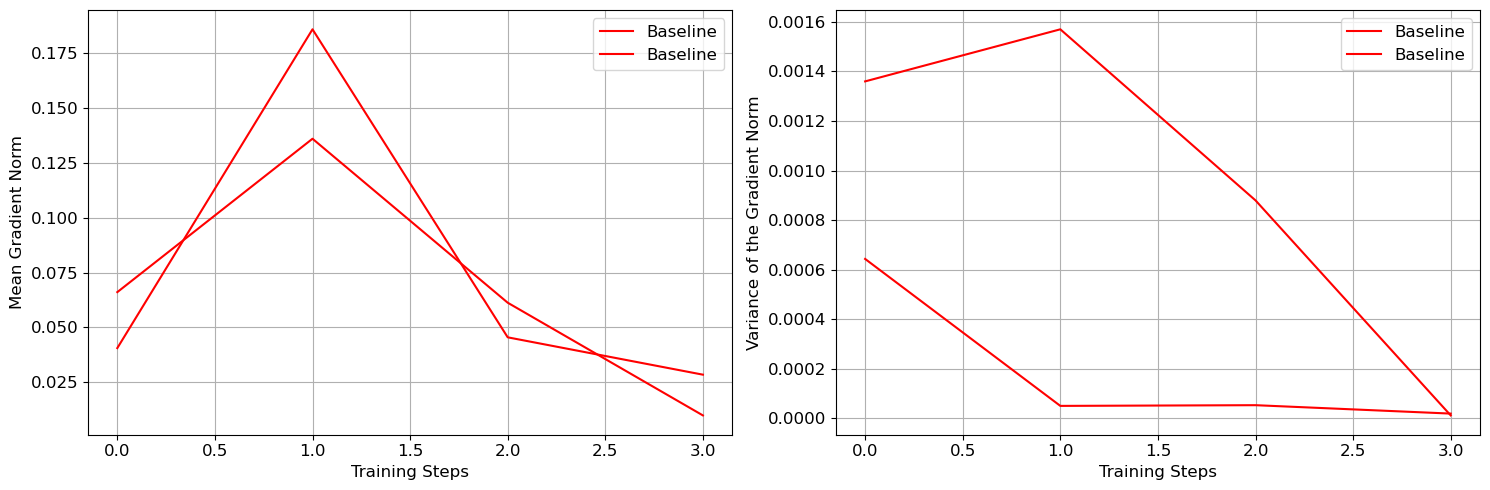

In [108]:
test_path= ["../../../../data/CartPole-v1/test"]


test = Analysis(test_path[0])
test_mean, test_std = test.calculate_mean_variance_gradients()

fig, axs = plt.subplots(1,2,figsize=(15,5), tight_layout=True)

axs[0].plot(test_mean, color = "red", label="Baseline")
axs[0].set_xlabel("Training Steps", fontsize=12)
axs[0].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

axs[1].plot(test_std, color = "red", label="Baseline")
axs[1].set_xlabel("Training Steps", fontsize=12)
axs[1].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.show()

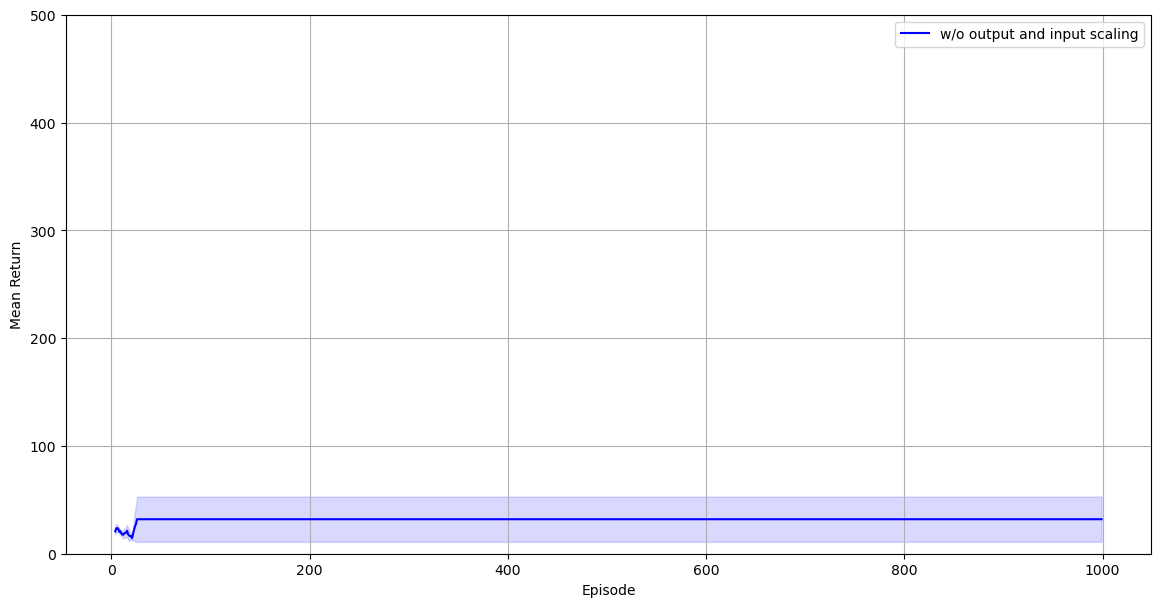

In [ ]:
moving_rewards_plot(test_path, ['w/o output and input scaling','w/o output scaling','w/o input scaling,',' '], 5)

In [ ]:
softmax_fixed_betas_paths =["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/output_dim_tests/output_1_dim",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/output_dim_tests/output_n_actions_dim"]

moving_rewards_plot(softmax_fixed_betas_paths, ['1 Dimension','N Dimension'], 10)